# CNN Training

Target is to train a CNN network to extract the needle position of an analog needle device.

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 


loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::


In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(3855, 32, 32, 3)
(3855, 2)


### Define the model

The layout of the network is a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [9]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(64, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,966 (304.55 KB)

 Trainable params: 77,960 (304.53 KB)

 Non-trainable params: 6 (24.00 B)

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [10]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(
    width_shift_range=[-Shift_Range, Shift_Range], 
    height_shift_range=[-Shift_Range, Shift_Range], 
    brightness_range=[1 - Brightness_Range, 1 + Brightness_Range]
)

# Data iterators
train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

# Compile the model before fitting
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']  
)

# Train the model
history = model.fit(train_iterator, validation_data=validation_iterator, epochs=Epoch_Anz)

Epoch 1/30
  6/386 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5010 - loss: 0.0060 

c:\Users\soura\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/386 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5113 - loss: -0.1879 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4918 - loss: -0.1155 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5046 - loss: -0.6301 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5257 - loss: -0.4727 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5097 - loss: -0.0190 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5115 - loss: -0.1539 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5150 - loss: -0.2734 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5143 - loss: -0.4547 - val_accuracy

### Step 1: Learing result
 
* Visualization of the training and validation results

c:\Users\soura\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


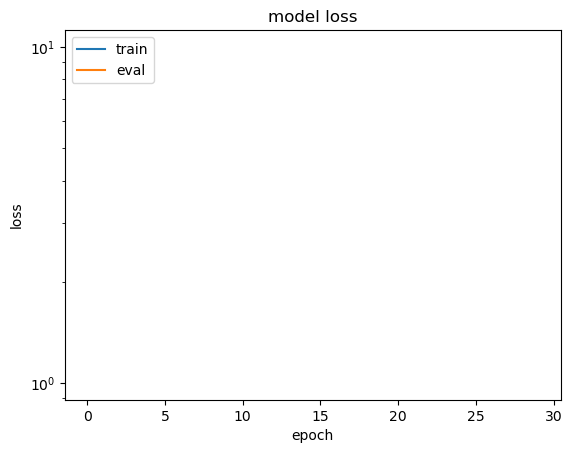

In [11]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [12]:
Batch_Size = 8
Epoch_Anz = 80
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(
    width_shift_range=[-Shift_Range, Shift_Range], 
    height_shift_range=[-Shift_Range, Shift_Range], 
    brightness_range=[1 - Brightness_Range, 1 + Brightness_Range]
)

# Data iterators
train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

# Use model.fit instead of model.fit_generator
history = model.fit(train_iterator, validation_data=validation_iterator, epochs=Epoch_Anz)

Epoch 1/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5256 - loss: -0.4486 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 2/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5034 - loss: -0.1782 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 3/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4916 - loss: -0.0029 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 4/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5159 - loss: -0.4928 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 5/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5124 - loss: -0.0198 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 6/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5014 - loss: -0.1597 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 7/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5037 - loss: -0.0690 - val_accuracy: 0.5344 - val_loss: -0.5883
Epoch 8/80
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5025 - loss: -0.0206

### Overall Learing results (Step 1 & Step 2)

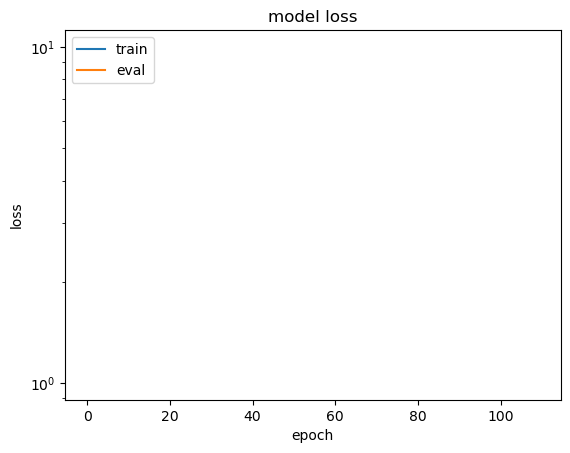

In [13]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(loss_ges)
plt.semilogy(val_loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [14]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
i = 0
deviation_max_list = 0.03

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))
    i+=1

res = np.asarray(res)
res_step_1 = res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
data_resize_all\0.0_Lfd-0000_zeiger1_2019-06-04T044009.jpg 0.0 0.33150000599946083 -0.33150000599946083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
data_resize_all\0.0_Lfd-0001_zeiger1_2019-06-04T045009.jpg 0.0 0.33164082173284926 -0.33164082173284926
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_resize_all\0.0_Lfd-0002_zeiger1_2019-06-04T050010.jpg 0.0 0.331591530534339 -0.331591530534339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
data_resize_all\0.0_Lfd-0003_zeiger2_2019-06-02T201009.jpg 0.0 0.3324520964242652 -0.3324520964242652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
data_resize_all\0.0_Lfd-0004_zeiger2_2019-06-06T113009.jpg 0.0 0.33237734379834893 -0.33237734379834893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
data_resize_all\0.0_Lfd-0005_zeiger3_2019-06-03T054009.jpg 0.0 0.3315063428971908 -0.3315063428971908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_resize_all\0.0_Lfd-0006_zeiger3_2019-06-05T192009.jpg 0.0 0.3321072477621703 -0.3321072477621703
1/1 ━━━━━━━━━━━

## Results

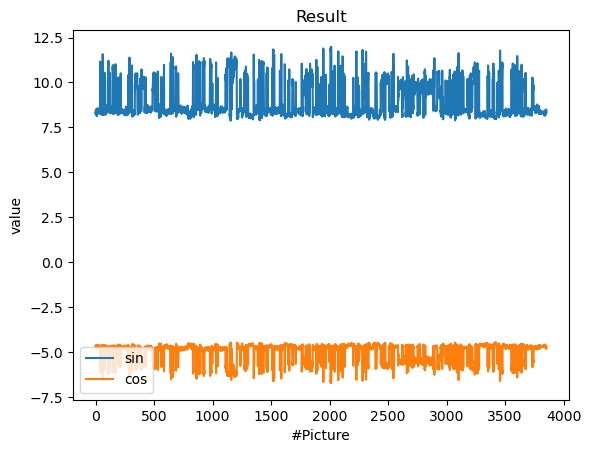

In [15]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

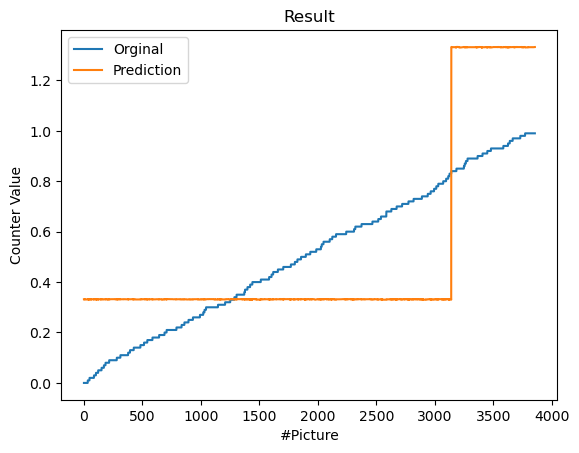

In [16]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

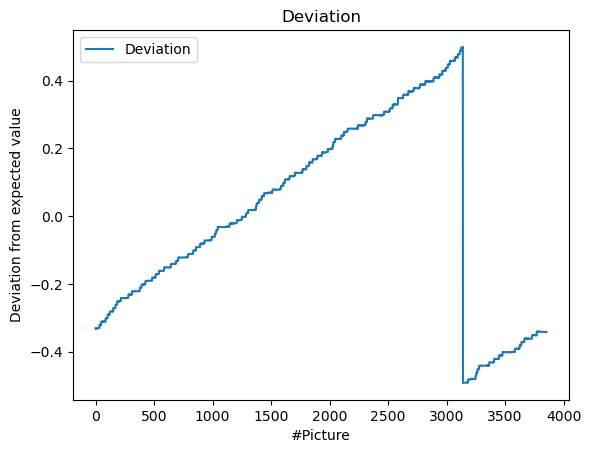

[-0.0065  0.283  -0.4927  0.4997]


In [17]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

In [20]:
model.save("CNN_Analog-Readout_Version1.h5")